# Gradient Boosting Desicion Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.

Antes que nada, carguemos el entorno de trabajo


In [94]:
%pip install optuna==3.6.1

Note: you may need to restart the kernel to use updated packages.


In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle


In [96]:

# base_path = "/content/drive/MyDrive/Colab Notebooks/Data Mining en Economia y Finanzas/"
# db_path = base_path + "/db"
# try:
#   data = pd.read_csv(base_path + 'competencia_01_con_clase.csv')
#   print("Columnas del DataFrame:")
#   print(data.columns)
# except FileNotFoundError:
#   print("Error: El archivo no fue encontrado. Por favor, verifica la ruta.")

In [97]:
base_path = 'C:\\Users\\janic\\OneDrive\\Documentos\\'
dataset_path = base_path + 'datos\\'
modelos_path = base_path + 'modelos\\'
db_path = base_path + 'db\\'
dataset_file = 'competencia_01_con_clase.csv'

ganancia_acierto = 780000
costo_estimulo = 20000

mes_train = [202102,202101,202103]
mes_test = 202104

# agregue sus semillas
semillas = [17,19,23,29,31]

data = pd.read_csv(base_path + dataset_file)

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [98]:
# # -------------------------------
# # 3️⃣ Ratios y agregados
# # -------------------------------
# data['nis_ratio_activos_prestamos'] = (data['mactivos_margen'] + data['mpasivos_margen']) / (data['mprestamos_personales'] + data['mprestamos_hipotecarios'] + 1)
# data['nis_ratio_comisiones_rentabilidad'] = data['mcomisiones'] / (data['mrentabilidad'] + 1)

# # Total consumo tarjetas
# data['nis_total_tarjetas_consumo'] = data['mtarjeta_visa_consumo'] + data['mtarjeta_master_consumo']

# # Proporción de transacciones digitales
# data['nis_prop_transacciones_digital'] = (data['chomebanking_transacciones'] + data['cmobile_app_trx']) / (data['ctrx_quarter'] + 1)

# # -------------------------------
# # 4️⃣ Lags y diferencias para comportamiento temporal
# # -------------------------------
# data = data.sort_values(['numero_de_cliente', 'foto_mes'])

# lag_cols = [
#     'ctrx_quarter', 'cproductos', 'tcuentas', 'nis_total_tarjetas_consumo',
#     'mrentabilidad', 'mcuentas_saldo'
# ]

# for col in lag_cols:
#     # Lags de 1, 2 y 3 meses
#     data[f'nis_{col}_lag1'] = data.groupby('numero_de_cliente')[col].shift(1)
#     data[f'nis_{col}_lag2'] = data.groupby('numero_de_cliente')[col].shift(2)
#     data[f'nis_{col}_lag3'] = data.groupby('numero_de_cliente')[col].shift(3)

#     # Diferencias
#     data[f'nis_delta_1_{col}'] = data[col] - data[f'nis_{col}_lag1']
#     data[f'nis_delta_2_{col}'] = data[col] - data[f'nis_{col}_lag2']
#     data[f'nis_delta_3_{col}'] = data[col] - data[f'nis_{col}_lag3']

#     # Promedio móvil 3 meses (actual + 2 anteriores)
#     data[f'nis_{col}_media_3'] = data[[col, f'nis_{col}_lag1', f'nis_{col}_lag2']].mean(axis=1)

#     # Max y min móvil
#     data[f'nis_{col}_max_3'] = data[[col, f'nis_{col}_lag1', f'nis_{col}_lag2']].max(axis=1)
#     data[f'nis_{col}_min_3'] = data[[col, f'nis_{col}_lag1', f'nis_{col}_lag2']].min(axis=1)

# # Crecimiento y volatilidad de ctrx_quarter
# data['nis_crecimiento_ctrx_quarter'] = data['nis_delta_1_ctrx_quarter'] / (data['nis_ctrx_quarter_lag1'] + 1)
# data['nis_volatilidad_ctrx_quarter'] = data.groupby('numero_de_cliente')['ctrx_quarter'].rolling(3).std().reset_index(0, drop=True)

# # -------------------------------
# # 5️⃣ Flags de riesgo
# # -------------------------------
# data['nis_flag_baja_riesgo'] = ((data['nis_delta_1_ctrx_quarter'] < 0) & (data['active_quarter'] == 0)).astype(int)


In [99]:
# ======================================================
# 🔧 Feature Engineering limpio con prefijo "nis_"
# ======================================================

import pandas as pd
import numpy as np

# Función auxiliar: crea columna solo si existen todas las columnas requeridas
def safe_create(data, col_name, cols_needed, func):
    if all(c in data.columns for c in cols_needed):
        data[col_name] = func(data)
    else:
        faltantes = [c for c in cols_needed if c not in data.columns]
        print(f"[Aviso] No se creó '{col_name}' (faltan columnas: {faltantes})")

# ----------------------------------------------
# 1️⃣ Features base ya existentes
# ----------------------------------------------

safe_create(data, 'nis_ratio_saldo_cuenta', ['mcuentas_saldo', 'mpayroll'],
            lambda d: d['mcuentas_saldo'] / (d['mpayroll'] + 1))

safe_create(data, 'nis_ratio_consumo_tarjetas', ['mtarjeta_visa_consumo', 'mtarjeta_master_consumo', 'ctrx_quarter'],
            lambda d: (d['mtarjeta_visa_consumo'] + d['mtarjeta_master_consumo']) / (d['ctrx_quarter'] + 1))

safe_create(data, 'nis_ratio_prestamos_sobre_ingresos', ['mprestamos_personales', 'mprestamos_hipotecarios', 'mpayroll'],
            lambda d: (d['mprestamos_personales'] + d['mprestamos_hipotecarios']) / (d['mpayroll'] + 1))

safe_create(data, 'nis_prop_transacciones_digital', ['chomebanking_transacciones', 'cmobile_app_trx', 'ctrx_quarter'],
            lambda d: (d['chomebanking_transacciones'] + d['cmobile_app_trx']) / (d['ctrx_quarter'] + 1))

# ----------------------------------------------
# Lags y deltas importantes
# ----------------------------------------------
lag_cols = ['ctrx_quarter', 'cproductos', 'mrentabilidad']  # eliminadas las de importancia 0
for col in lag_cols:
    if col in data.columns:
        for lag in [1, 2]:
            data[f'nis_lag{lag}_{col}'] = data.groupby('numero_de_cliente')[col].shift(lag)
        data[f'nis_delta_1_{col}'] = data[col] - data.groupby('numero_de_cliente')[col].shift(1)
        data[f'nis_media_3_{col}'] = data.groupby('numero_de_cliente')[col].rolling(3).mean().reset_index(0, drop=True)

# ----------------------------------------------
# Flags importantes
# ----------------------------------------------
if 'ctrx_quarter' in data.columns:
    data['nis_flag_cta_sin_mov'] = (data['ctrx_quarter'] == 0).astype(int)
if 'mrentabilidad' in data.columns:
    data['nis_flag_baja_rentabilidad'] = (data['mrentabilidad'] < 0).astype(int)
if 'nis_delta_1_ctrx_quarter' in data.columns:
    data['nis_flag_actividad_creciente'] = (data['nis_delta_1_ctrx_quarter'] > 0).astype(int)

# ----------------------------------------------
# Ratios financieros
# ----------------------------------------------
safe_create(data, 'nis_ratio_deuda_ingreso', ['mprestamos_personales', 'mprestamos_hipotecarios', 'mpayroll'],
            lambda d: (d['mprestamos_personales'] + d['mprestamos_hipotecarios']) / (d['mpayroll'] + 1))

safe_create(data, 'nis_ratio_consumo_limite', ['mtarjeta_visa_consumo', 'mtarjeta_master_consumo', 'Visa_mlimitecompra', 'Master_mlimitecompra'],
            lambda d: (d['mtarjeta_visa_consumo'] + d['mtarjeta_master_consumo']) / (d['Visa_mlimitecompra'] + d['Master_mlimitecompra'] + 1))

safe_create(data, 'nis_ratio_saldo_limite', ['Visa_msaldototal', 'Master_msaldototal', 'Visa_mlimitecompra', 'Master_mlimitecompra'],
            lambda d: (d['Visa_msaldototal'] + d['Master_msaldototal']) / (d['Visa_mlimitecompra'] + d['Master_mlimitecompra'] + 1))

safe_create(data, 'nis_ratio_pago_deuda', ['Visa_mpagado', 'Master_mpagado', 'Visa_msaldototal', 'Master_msaldototal'],
            lambda d: (d['Visa_mpagado'] + d['Master_mpagado']) / (d['Visa_msaldototal'] + d['Master_msaldototal'] + 1))

# ----------------------------------------------
# Actividad digital
# ----------------------------------------------
safe_create(data, 'nis_ratio_digital_sobre_total', ['chomebanking_transacciones', 'cmobile_app_trx', 'ctrx_quarter'],
            lambda d: (d['chomebanking_transacciones'] + d['cmobile_app_trx']) / (d['ctrx_quarter'] + 1))
if all(c in data.columns for c in ['numero_de_cliente', 'nis_ratio_digital_sobre_total']):
    data['nis_delta_1_digital'] = data['nis_ratio_digital_sobre_total'] - data.groupby('numero_de_cliente')['nis_ratio_digital_sobre_total'].shift(1)

# ----------------------------------------------
# Tendencias / estabilidad
# ----------------------------------------------
if all(c in data.columns for c in ['numero_de_cliente', 'mcuentas_saldo']):
    data['nis_volatilidad_saldo'] = data.groupby('numero_de_cliente')['mcuentas_saldo'].rolling(3).std().reset_index(0, drop=True)
if all(c in data.columns for c in ['numero_de_cliente', 'mrentabilidad']):
    data['nis_delta_1_rentabilidad'] = data['mrentabilidad'] - data.groupby('numero_de_cliente')['mrentabilidad'].shift(1)

# ----------------------------------------------
# Flags adicionales importantes
# ----------------------------------------------
if all(c in data.columns for c in ['Visa_delinquency', 'Master_delinquency']):
    data['nis_flag_mora'] = ((data['Visa_delinquency'] == 1) | (data['Master_delinquency'] == 1)).astype(int)
if all(c in data.columns for c in ['Visa_status', 'Master_status']):
    data['nis_flag_cierre_tarjeta'] = ((data['Visa_status'] > 0) | (data['Master_status'] > 0)).astype(int)
if 'ctrx_quarter' in data.columns:
    data['nis_flag_sin_movimiento'] = (data['ctrx_quarter'] == 0).astype(int)
if 'nis_delta_1_ctrx_quarter' in data.columns:
    data['nis_flag_baja_actividad'] = (data['nis_delta_1_ctrx_quarter'] < -5).astype(int)

# ----------------------------------------------
# Interacciones simples
# ----------------------------------------------
safe_create(data, 'nis_interaccion_ingresos_rentabilidad', ['mpayroll', 'mrentabilidad'],
            lambda d: d['mpayroll'] * d['mrentabilidad'])
safe_create(data, 'nis_interaccion_saldo_consumo', ['mcuentas_saldo', 'mtarjeta_visa_consumo', 'mtarjeta_master_consumo'],
            lambda d: d['mcuentas_saldo'] * (d['mtarjeta_visa_consumo'] + d['mtarjeta_master_consumo']))
safe_create(data, 'nis_interaccion_digital_saldo', ['nis_ratio_digital_sobre_total', 'mcuentas_saldo'],
            lambda d: d['nis_ratio_digital_sobre_total'] * d['mcuentas_saldo'])

# ----------------------------------------------
# Limpieza final
# ----------------------------------------------
data.replace([np.inf, -np.inf], np.nan, inplace=True)


In [100]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

Además, como se mencionó en la clase pasada, comenzaremos a experimentar con nuevas clases para ajustar el modelo. En particular, sumaremos la clase **BAJA+1**, que es estructuralmente muy similar a **BAJA+2**, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [101]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

In [102]:
#train_data = data[data['foto_mes'] == mes_train]
train_data = data[data['foto_mes'].isin(mes_train)]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_binaria2 = test_data['clase_binaria2']

w_test = test_data['clase_peso']

Y preparamos el *dataset* para poder usar el **rf** de una clase anterior.

In [103]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
Xif = imp_mean.fit_transform(X_test)

In [104]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

LGBM necesita su propio tipo de Datasets:

In [105]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función **cv** que viene *out-of-the-box*

In [106]:
cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

Y vizualizamos los resultados de ambas ejecuciones:

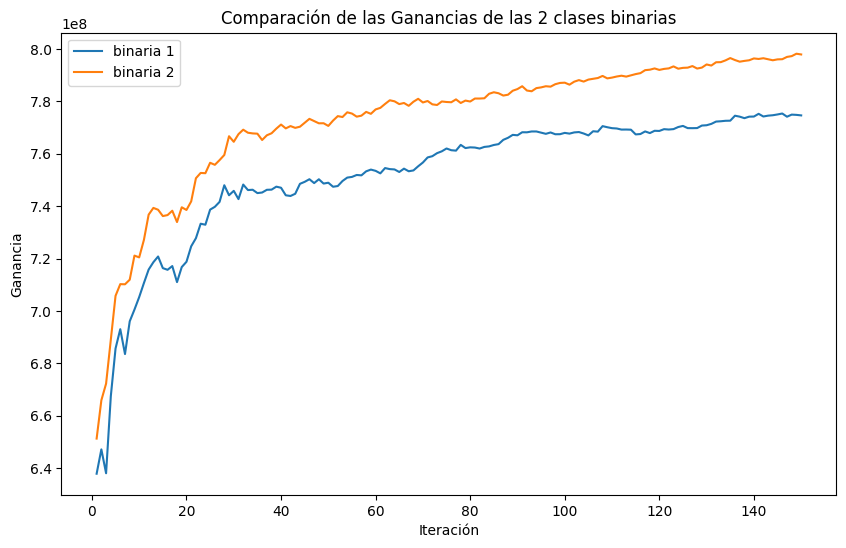

In [107]:
df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


No parece haber un diferencia sustancial. **Pero** solo hicimos una ejecución. De tarea prueba esta estrategia correctamente.

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**. Cabe destacar que las optimizaciones que realizaremos son básicas y están diseñadas para ejecutarse en pocos minutos. Será su responsabilidad ampliar tanto el rango de búsqueda como el tiempo de optimización para obtener un modelo más competitivo.


In [108]:

def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_301_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2025-10-06 19:27:32,545] Using an existing study with name 'exp_301_lgbm' instead of creating a new one.


In [109]:
# study.optimize(objective, n_trials=100) # subir subir

Analizamos los resultados as usual

In [110]:
optuna.visualization.plot_optimization_history(study)

In [111]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [112]:
plot_slice(study)

In [113]:
plot_contour(study)

In [114]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [115]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(best_iter)


num_leaves = study.best_trial.params['num_leaves']
learning_rate = study.best_trial.params['learning_rate']
min_data_in_leaf = study.best_trial.params['min_data_in_leaf']
feature_fraction = study.best_trial.params['feature_fraction']
bagging_fraction = study.best_trial.params['bagging_fraction']


print("num_leaves:", study.best_trial.params['num_leaves'])
print("learning_rate:", study.best_trial.params['learning_rate'])
print("min_data_in_leaf:", study.best_trial.params['min_data_in_leaf'])
print("feature_fraction:", study.best_trial.params['feature_fraction'])
print("bagging_fraction:", study.best_trial.params['bagging_fraction'])


99
num_leaves: 96
learning_rate: 0.10786251291535232
min_data_in_leaf: 844
feature_fraction: 0.817823789674196
bagging_fraction: 0.9701924741567449


In [116]:
#best_iter = study.best_trial.user_attrs["best_iter"]
best_iter = 98
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'min_data_in_leaf': min_data_in_leaf,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 98


Observamos la variables más importantes para el modelo:

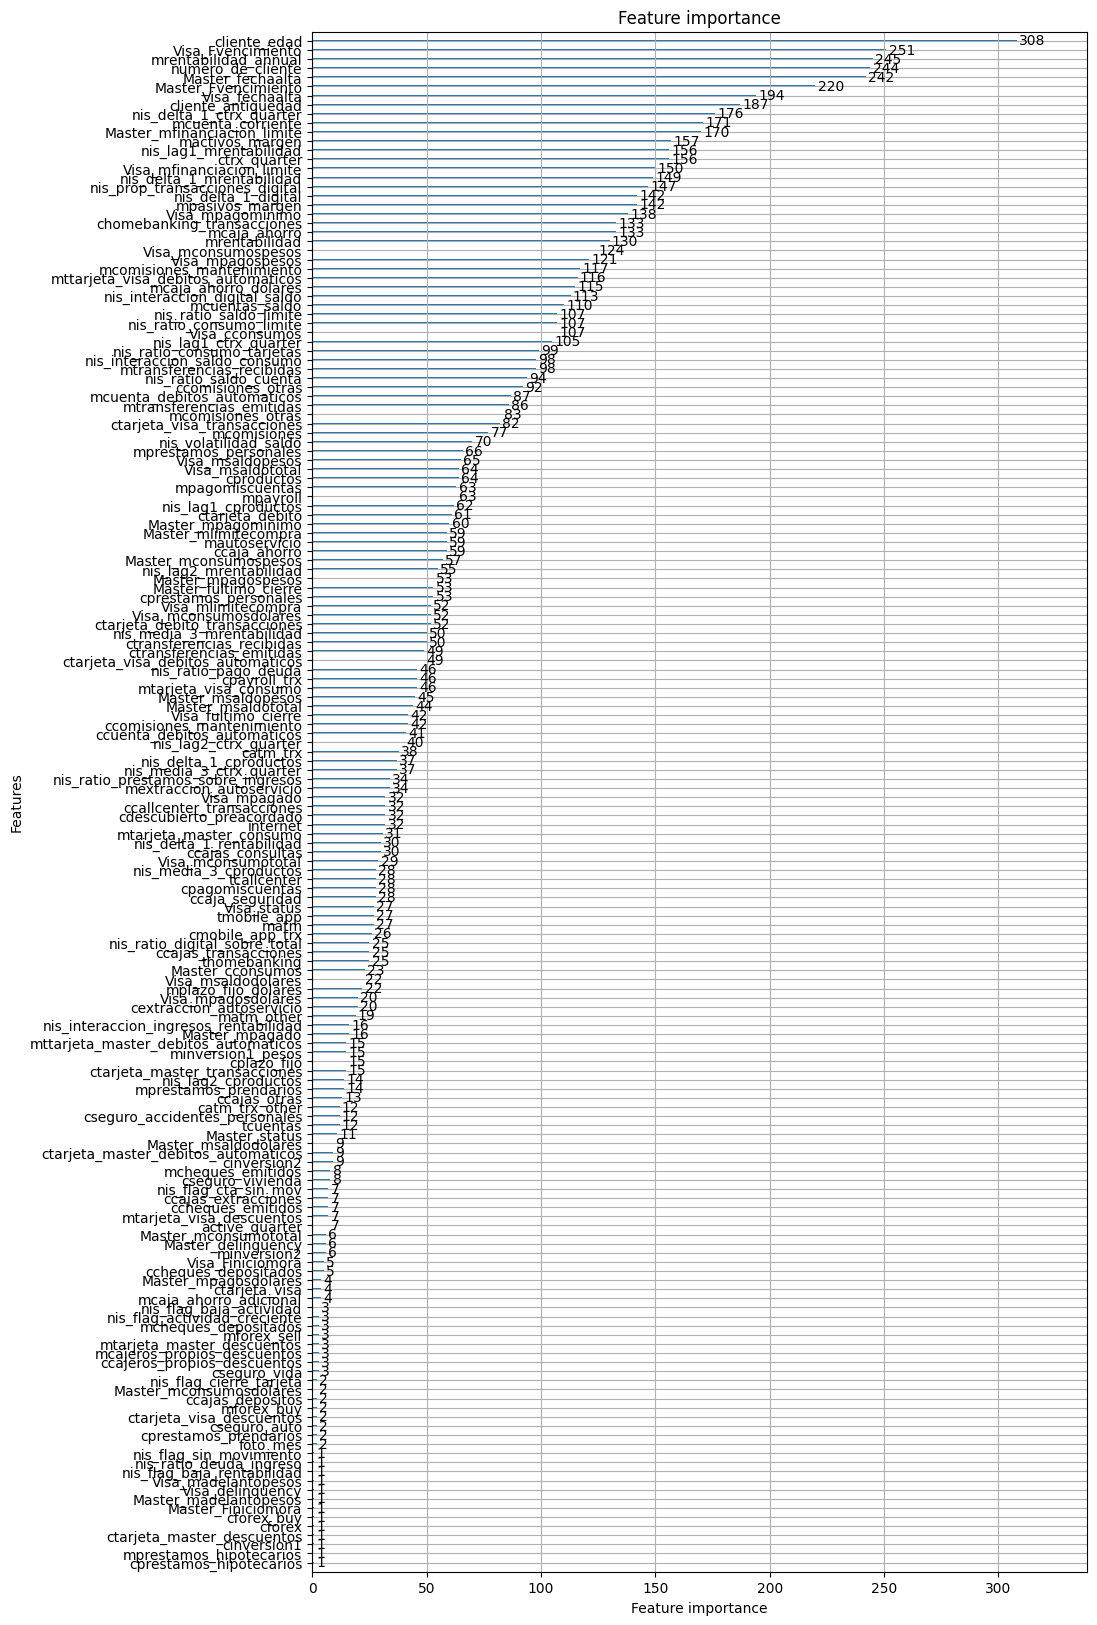

In [117]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [118]:
# Variables que empiezan con 'nis_'
nis_cols = [c for c in data.columns if c.startswith('nis_')]

# Importancia de estas variables según el Booster
importancias_nis = pd.Series(model.feature_importance(), index=model.feature_name())
importancias_nis = importancias_nis[importancias_nis.index.isin(nis_cols)]

# Mostrar las 10 menos importantes
importancias_nis.sort_values().head(20)




nis_flag_mora                             0
nis_flag_sin_movimiento                   1
nis_ratio_deuda_ingreso                   1
nis_flag_baja_rentabilidad                1
nis_flag_cierre_tarjeta                   2
nis_flag_baja_actividad                   3
nis_flag_actividad_creciente              3
nis_flag_cta_sin_mov                      7
nis_lag2_cproductos                      14
nis_interaccion_ingresos_rentabilidad    16
nis_ratio_digital_sobre_total            25
nis_media_3_cproductos                   28
nis_delta_1_rentabilidad                 30
nis_ratio_prestamos_sobre_ingresos       34
nis_delta_1_cproductos                   37
nis_media_3_ctrx_quarter                 37
nis_lag2_ctrx_quarter                    40
nis_ratio_pago_deuda                     46
nis_media_3_mrentabilidad                50
nis_lag2_mrentabilidad                   55
dtype: int32

In [119]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


feature  importance
5                  cliente_edad         308
135           Visa_Fvencimiento         251
8          mrentabilidad_annual         245
0             numero_de_cliente         244
127            Master_fechaalta         242
..                          ...         ...
132            Visa_delinquency           1
114          Master_Finiciomora           1
121       Master_madelantopesos           1
69   ctarjeta_master_descuentos           1
75                       cforex           1

[168 rows x 2 columns]

Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [120]:
model.save_model(modelos_path + 'lgb_first.txt')

Y recuperar el mismo desde ese formato

In [121]:
model = lgb.Booster(model_file=modelos_path + 'lgb_first.txt')

Para realizar nuestra habitual comparación de modelos, partiremos desde el mejor que obtuvimos hasta ahora, el **rf**. Para este fin cargaremos el *binario* que ajustamos un par de clases atrás:

In [122]:
# filename_rf_1000 = modelos_path + 'exp_206_random_forest_model_1000.sav'
# model_rf_1000 = pickle.load(open(filename_rf_1000, 'rb'))

Y sobre ambos modelos obtenemos la predicción de **Abril**

In [123]:
# y_pred_rf = model_rf_1000.predict_proba(Xif)
# y_pred_rf = y_pred_rf[:,1] # adaptamos la salida para que sea homogénea con el LGBM

y_pred_lgm = model.predict(X_test)

Finalmente medimos las ganancias de ambos

In [124]:
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop

print("Ganancia LGBM 1:", ganancia_prob(y_pred_lgm, y_test_binaria1))
print("Ganancia LGBM 2:", ganancia_prob(y_pred_lgm, y_test_binaria2))


Ganancia LGBM 1: 339580000.0
Ganancia LGBM 2: 989980000.0


Vemos un nuevo salto, tan alto como el del árbol al rf. Será simplemente suerte? veamos que sucede sobre múltiples **LDB**

In [125]:
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                             test_size=0.3,
                             random_state=semillas[0])
modelos = {"lgbm":y_pred_lgm}
rows = []
for private_index, public_index in sss_futuro.split(X_test, y_test_binaria2):
  row = {}
  for name, y_pred in modelos.items():
    row[name + "_public"] = ganancia_prob(y_pred[public_index], y_test_binaria2.iloc[public_index], 0.3)
    row[name + "_private"] = ganancia_prob(y_pred[private_index], y_test_binaria2.iloc[private_index], 0.7)
  rows.append(row)
df_lb = pd.DataFrame(rows)


In [126]:
df_lb_long = df_lb.reset_index()
df_lb_long = df_lb_long.melt(id_vars=['index'], var_name='model_type', value_name='ganancia')
df_lb_long[['modelo', 'tipo']] = df_lb_long['model_type'].str.split('_', expand=True)
df_lb_long = df_lb_long[['ganancia', 'tipo', 'modelo']]

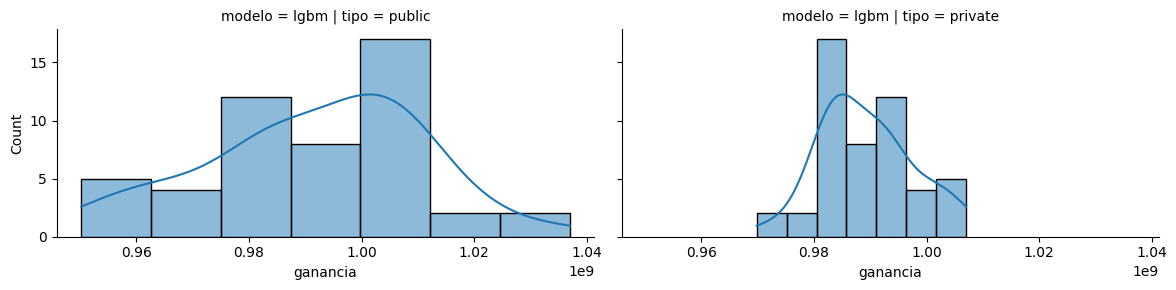

In [127]:
g = sns.FacetGrid(df_lb_long, col="tipo", row="modelo", aspect=2)
g.map(sns.histplot, "ganancia", kde=True)
plt.show()


Otra vez se observa la superioridad del **LGBM**. Veamos que hubiera pasado si elegíamos el mejor del público

In [128]:
df = pd.DataFrame()
df['best_public'] = df_lb.filter(regex='_public').idxmax(axis=1)
df['best_private'] = df_lb.filter(regex='_private').idxmax(axis=1)

pd.crosstab(df['best_public'], df['best_private'])

best_private  lgbm_private
best_public               
lgbm_public             50

Observamos que en 50 **LDBs** solo en un público ganó un **rf**, sin embargo en el 100% de los casos, en el privado ganó un **lgbm**. Asombroso.

Pero el alumno atento, vio que para la selección del mejor modelo no se utilizó ningún punto de corte. Podrá pasar que el mejor punto de corte en entrenamiento, no sea el mejor para un mes en el futuro?

Veamos para esto la curva de ganancia en función de los puntos de corte

In [129]:
ganancia = np.where(y_test_binaria2 == 1, ganancia_acierto, 0) - np.where(y_test_binaria2 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


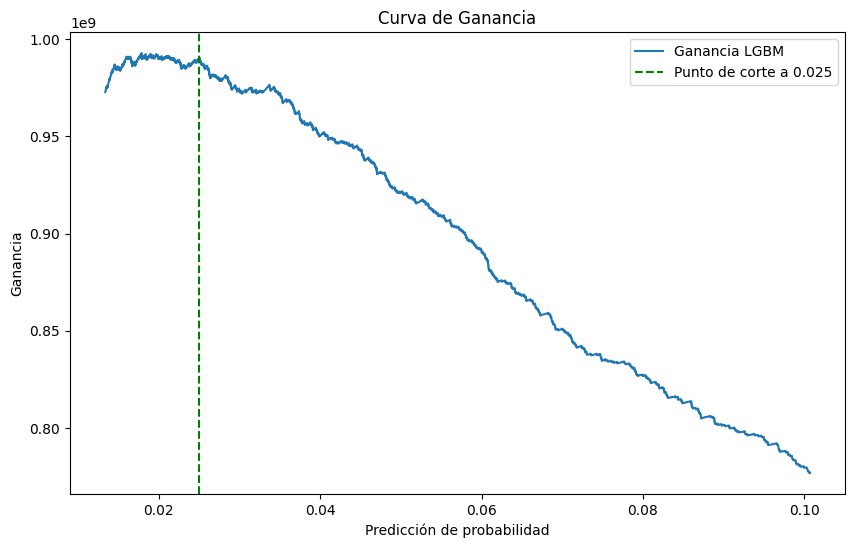

In [130]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()


In [131]:
idx_max = np.argmax(ganancia_cum[piso_envios:techo_envios])
prob_max = y_pred_lgm[piso_envios:techo_envios][idx_max]
ganancia_max = ganancia_cum[piso_envios:techo_envios][idx_max]

print(f"Máxima ganancia: {ganancia_max:.2f} en probabilidad {prob_max:.4f}")


Máxima ganancia: 992780000.00 en probabilidad 0.0179


Vaya! realmente nuestro teórico mejor punto de corte no es el que mayor ganancia genera. Es hora de cambiar el enfoque.

En vez de mirar el punto de corte, empezaremos a pensar en cuál es la cantidad máxima de clientes que se deben estimular. Si cambiamos a esto, veremos que el gráfico anterior se ve así

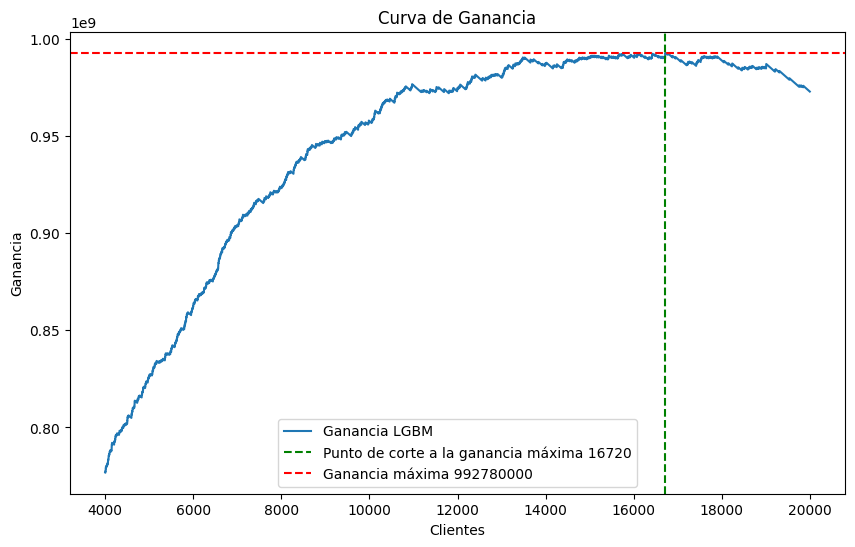

In [132]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


Lo que significa que la cantidad de envíos que maximiza la ganancia es 12601.

Claro, estamos haciendo trampa. No nunca vamos a contar con datos del futuro para determinar este punto de corte.


In [142]:
# Load data for 202106
data_202106 = data[data['foto_mes'] == 202106].copy()

# Preprocess the data (same as training and testing data)
X_202106 = data_202106.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
# Removed imputation: X_202106_imputed = imp_mean.transform(X_202106)

# Make predictions using the trained LightGBM model (from cell bwyUriQksZAM)
# Using X_202106 directly, assuming no missing values or LightGBM is configured to handle them
y_pred_202106 = model.predict(X_202106)

# --- Display summary statistics of predictions ---
print("\nSummary statistics of predicted probabilities:")
print(pd.Series(y_pred_202106).describe())
# -------------------------------------------------


# Apply a fixed threshold of 0.025
fixed_threshold = 0.0233
data_202106['predicted'] = np.where(y_pred_202106 >= fixed_threshold, 1, 0)

# Create the output DataFrame with numero_de_cliente and predicted columns
output_df = data_202106[['numero_de_cliente', 'predicted']]

# Count the number of predicted positives and print it
num_predicted_positives = output_df['predicted'].sum()
print(f"\nNumber of predicted positives in 202106 with threshold {fixed_threshold}: {num_predicted_positives}")

# Save the predictions to a CSV file
output_path = base_path + 'predicciones_202106_01.csv'
output_df.to_csv(output_path, index=False)

print(f"Predictions saved to: {output_path}")



Summary statistics of predicted probabilities:
count    164313.000000
mean          0.010344
std           0.045149
min           0.000005
25%           0.000181
50%           0.000606
75%           0.003311
max           0.985928
dtype: float64

Number of predicted positives in 202106 with threshold 0.0233: 13305
Predictions saved to: C:\Users\janic\OneDrive\Documentos\predicciones_202106_01.csv
